In [51]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# For regression trees
import pygraphviz as pgv

# For a bit more data exploration
from sklearn.tree import DecisionTreeRegressor  # Import Decision Tree Regressor
from sklearn.tree import export_graphviz

import seaborn as sns

sns.set(style="ticks", color_codes=True)
%matplotlib inline
# %matplotlib notebook

# Introduction

The aim of this notebook is to use a shorter temporal aggregation than that used in NB01, and to only look at the time before the peaks in cyanobacteria and chl-a when calculating summary statistics for the potential explanatory variables. The hope is to tease out more causative relationships, rather than just correlative ones.

Notebooks steps:

1) Generate data matrices including potential features of use in predicting lake chemistry and ecology in Lake Vansjø. Data is read in for the River Hobøl and Lake Vansjø in the Morsa vannområde. Data includes meteorological data, NVE discharge data, river chemistry data and lake chemistry and ecology data for the period ca. 1980-2018.

2) In contrast to NB01, in this notebook a shorter temporal aggregation is used: First, pick out the target variable per year. This is the month where the average is highest for that year. Explanatory variables are then averages or sums for the previous n days (e.g. 14 - 90 days).

3) Carry out exploratory data analysis to help identify potentially important relationships. This includes exploration of correlation coefficients and some graphs. Data matrices for chl-a concentration and biovolume of cyanobacteria are written to csv for use elsewhere.

This notebook builds on notebook A_Make_data_matrix.ipynb, where the aim was monthly rather than seasonal aggregation of the data. Notebook A contains some more exploration of the daily data and explanations for some of the data cleaning choices made.

**Note: this notebook was done in a horrid rush, and needs tidying up!**

Created by Leah JB. Part of the ERA4CS WATExR project.

# Paths to files and folders

In [52]:
# User input
# Which Vansjø basin? Van1 (Storefjorden), Van2 (Vanemfjorden)
basin = 'Van2'

# Include TP flux estimates in the data matrix?
inc_fluxes = 0  # 0 or 1

# Include features from Van1 in Van2's features? Only relevant if basin is Van2
inc_Van1 = 0

# FILE PATHS to input data

# Met (T, pptn, wind)
met_source = 'metno'  # Choose one of: 'metno', 'era5'
met_fpath_dict = {'metno': r'../../../Data/Meteorological/Obs_metno/Obs_Metno_1km_gridded_Morsa_v2.csv',
                  'era5': r'../../../Data/Meteorological/06_era5/era5_morsa_1980-2019_daily.csv'}
if met_source == 'metno':  # Wind is in a separate file
    wind_fpath = r'../../../Data/Meteorological/Obs_metno/Obs_Rygge_MeanWindSpeed.csv'  # Mean daily wind speed (m/s), Rygge

# PET
PET_fpath = r'../../Data/ExploratoryInput/Morsa_ThornthwaitePET.csv'  # N.B. calculated using met station temp rather than gridded. But the two are v. comparable (not so pptn)

# Discharge
Q_fpath = r'../../../Data/Discharge/3-22-0_D6pm_Hogfoss_Scaled_to_Kure.csv'

# Catchment water quality (at Kure)
catchwq_fpath = r'../../../Data/Observed_Chem_Ecol/003-59191_Hobølelva_Kure_chem_obs.csv'

# Lake water quality
lakewq_fpath_dict = {'Van1': r'../../Data/ExploratoryInput/Van1_Storefjorden_chem_obs_to2017.csv',
                     'Van2': r'../../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_chem_obs.csv'}

# Alternative lake colour data (from Storefjorden, 20m depth, MOVAR data)
movar_color_fpath = r'../../../Data/Observed_Chem_Ecol/LakeColour_MOVAR.csv'

# Lake ecology (PTI, biovolume, cyanomax, cyano biovolume)
ecol_fpath_dict = {'Van1': r'../../Data/ExploratoryInput/Van1_PTI_Cyano_to2018.xlsx',
                   'Van2':  r'../../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_Cyanobacteria.csv'}

# Output folders
out_file = r'../../Data/DataMatrices'
corr_coeff_folder = r'../../Data/CorrelationCoeffs'
graph_outfolder = r'../../Figures'

# Read in daily data

In [53]:
# READ IN
met_fpath = met_fpath_dict[met_source]
met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=True)
if met_source == 'metno':
    wind_df = pd.read_csv(wind_fpath, index_col=0, parse_dates=True, dayfirst=True)

pet_df = pd.read_csv(PET_fpath, index_col=0, parse_dates=True, dayfirst=True)
Q_df = pd.read_csv(Q_fpath, index_col=0, parse_dates=True, dayfirst=True)

catchwq_df = pd.read_csv(catchwq_fpath, index_col=0, parse_dates=True, dayfirst=True)

lakewq_df = pd.read_csv(lakewq_fpath_dict[basin], index_col=0, parse_dates=True, dayfirst=True)
color_df = pd.read_csv(movar_color_fpath, index_col=0, parse_dates=True, dayfirst=True)

# If looking at Van2 (Vanemfjorden), also read in lake data from Storefjorden
if basin == 'Van2' and inc_Van1 == 1:
    lakewq_df_van1 = pd.read_csv(lakewq_fpath_dict['Van1'], index_col=0, parse_dates=True, dayfirst=True)

# Read in ecol data from excel sheet one sheet at a time, then merge
if basin == 'Van1':
    # Haven't updated Van1 beyond 2018
    ecol_fpath = ecol_fpath_dict['Van1']
    PTI_df = pd.read_excel(ecol_fpath, sheet_name=0, index_col=3, parse_dates=True)
    biovol_df = pd.read_excel(ecol_fpath, sheet_name=1, index_col=3, parse_dates=True)
    cyanoBiovol_df = pd.read_excel(ecol_fpath, sheet_name=2, index_col=0, parse_dates=True)
    ecol_df = pd.concat([PTI_df['PTI'], biovol_df['Biovolume_mm3_per_l'], cyanoBiovol_df['Cyano_biovol_mm3_per_l']], axis=1)
else:
    # For Van2, haven't updated PTI or biovolume data to 2019, only cyanobiovol
    ecol_fpath = ecol_fpath_dict['Van2']
    ecol_df = pd.read_csv(ecol_fpath, index_col=0, parse_dates=True, dayfirst=True)
    # convert units to mm3/l (mg/l if assume density is same as water)
    ecol_df['Cyano_biovol_mm3_per_l'] = ecol_df['Cyano_biovol_mm3_per_m3']/1000.
    ecol_df.drop(['Cyano_biovol_mm3_per_m3'], axis=1, inplace=True)

# Data cleaning and reorganising

For plots of data see notebook 01 (Make_data_matrix_monthly). That code is repeated here.

## Extract cols of interest from met and Q dfs

In [54]:
# MET DATA

# For the met data, just pick the columns of interest and rename them

if met_source == 'metno':
    met_df = met_df[['RR_catch','TG_catch']] # For now, pick rainfall and temp averaged over whole catchment, not just the lake
    met_df.columns = ['Pptn','Temp']
    met_df.index.name = 'Date'
    met_df.index = met_df.index.normalize() # Drop time info from metdf index
    # Add mean daily wind speed (m/s)
    met_df['Wind_speed'] = wind_df.iloc[:,0]

else:
    met_df['Wind_speed'] = np.sqrt((met_df['uas']**2) + (met_df['vas']**2))
    met_df = met_df[['tp','tas','Wind_speed']]
    met_df.columns = ['Pptn','Temp','Wind_speed']
    met_df.index.name = 'Date'

# Remove some dodgy-looking values
met_df.loc[met_df['Pptn'] < 0.,'Pptn'] = 0.

# Also add PET (mm/day)
met_df['PET'] = pet_df['PET']

met_df.head()

,Pptn,Temp,Wind_speed,PET
Date,,,,
1970-12-31,0.000000,-9.243695,4.6,NaN
1971-01-01,0.000000,-10.881015,0.2,0.0
1971-01-02,0.000000,-9.843024,0.3,0.0
1971-01-03,0.000000,-2.851721,6.0,0.0
1971-01-04,0.000096,-2.219738,2.2,0.0


In [55]:
# Q DATA
Q_df = Q_df['Q_18H_average_m3s_scaled']
Q_df.rename('Q', inplace=True)

Date
1976-09-23    0.089
1976-09-24    0.089
1976-09-25    0.089
1976-09-26    0.090
1976-09-27    0.088
              ...  
2018-09-25    0.392
2018-09-26    0.360
2018-09-27    0.399
2018-09-28    0.424
2018-09-29    0.370
Name: Q, Length: 11702, dtype: float64

## Process lake colour data

In [56]:
# Lake colour data (merge MOVAR and NIVA data). Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
lakewq_df = pd.merge(lakewq_df, color_df, left_index=True, right_index=True, how='outer')

# Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
s0 = lakewq_df.loc[:'1998-12-31','colour']

id1 = lakewq_df['Colour'].first_valid_index()
s1 = lakewq_df['Colour'].loc[id1:]
s1.name = 'colour'

lastidx = lakewq_df.loc['2013-01-01':,'colour'].last_valid_index()
s2 = lakewq_df.loc['2013-01-01':lastidx,'colour']

colour = pd.concat([s0, s1,s2], axis=0).dropna()

# Drop original MOVAR and NIVA colour series, and replace with the patched series
lakewq_df = lakewq_df.drop(['colour','Colour'], axis=1)
lakewq_df = lakewq_df.merge(colour.to_frame(), left_index=True, right_index=True, how='outer')

# Drop some dodgy-looking values
lakewq_df.loc[:'1982-08-01','colour'] = np.NaN
# lakewq_df[lakewq_df[['SS','SS_min']]>25.] = np.NaN

if basin == 'Van2' and inc_Van1==1:
    lakewq_df_van1.loc[:'1982-08-01','colour'] = np.NaN

## Combine data into one df, drop unwanted cols and rows

['Pptn' 'Temp' 'Wind_speed' 'PET' 'Q' 'TP_catch' 'chl-a_lake' 'TP_lake'
 'colour_lake' 'CyanoBiovol']


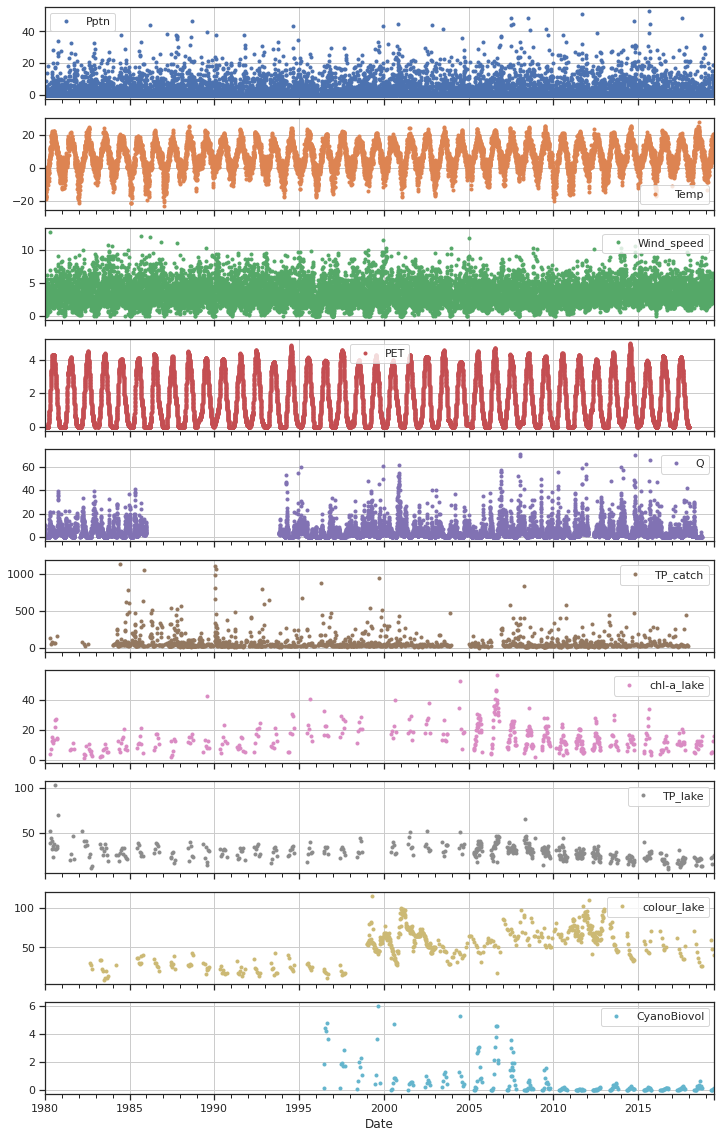

In [57]:
# Add suffixes to lake and water quality columns
catchwq_df = catchwq_df.add_suffix('_catch')
lakewq_df = lakewq_df.add_suffix('_lake')

if basin == 'Van2' and inc_Van1==1:
    lakewq_df_van1 = lakewq_df_van1.add_suffix('_van1')

# REINDEX & JOIN ALL DATASETS INTO ONE DATAFRAME

if basin == 'Van2' and inc_Van1==1:
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df, lakewq_df_van1]
else:
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df]

for i, df in enumerate(df_list):
    df = df.reindex(index=met_df.index)
    if i<1:
        daily_df = df
    else:
        daily_df = daily_df.join(df)

# Remove data pre-1980
daily_df = daily_df.loc['1980-01-01':,:]

# Drop some cols and rename others
if basin == 'Van2' and inc_Van1==1:
    cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch',
                    'TDP_lake','SS_lake','SS_min_lake',
                    'TOC_van1', 'TDP_van1', 'SS_min_van1', 'SS_van1',]
else:
    cols_to_drop = ['SS_min_catch', 'SS_catch', 'TDP_catch', 'SRP_catch']

var_rename_dict = {'Biovolume_mm3_per_l':'Biovolume',
                   'Cyano_biovol_mm3_per_l':'CyanoBiovol'}

daily_df.drop(cols_to_drop, axis=1, inplace=True)
daily_df.rename(var_rename_dict, axis=1, inplace=True)

# Check output
print(daily_df.columns.values)
daily_fig = daily_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3, figsize=(12,20), grid=True);

# plt.savefig(os.path.join(graph_outfolder,'daily_data_tseries.png'))


## Add precipitation-related features

Add derived variables from daily data.
Don't bother with residence time or fluxes as didn't seem important in monthly analysis, and for fluxes lots of missing vaules

Precipitation features:
rain day (boolean of whether it rained that day or not). There are various definitions and things we could use,
(e.g., from Australian Met service):
Wet days    Annual count of days with daily precipitation ≥ 1 mm
Heavy precipitation days    Annual count of days with daily precipitation ≥ 10 mm
Very heavy precipitation days    Annual count of days with daily precipitation ≥ 30 mm

Decide to go with 'Wet day' definition, to filter out small errors in values under 1mm (& which might be dew)

Also calculate the number of days with intense rainfall, where daily rain sum was over 10 mm.

                Pptn  Rain_day
Date                          
1980-01-01  0.000000         0
1980-01-02  0.000000         0
1980-01-03  0.000000         0
1980-01-04  2.669136         1
1980-01-05  2.806878         1
8.499137083600006
                Pptn  Pptn_intense
Date                              
1980-01-01  0.000000             0
1980-01-02  0.000000             0
1980-01-03  0.000000             0
1980-01-04  2.669136             0
1980-01-05  2.806878             0


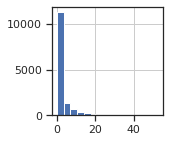

In [58]:
def rain_day(pptn):
    if pptn > 1:
        return 1
    else:
        return 0


daily_df["Rain_day"] = daily_df["Pptn"].map(rain_day)
print(daily_df[["Pptn", "Rain_day"]].head())

# (2) pptn intensity: Boolean saying whether precipitation is above a certain threshold
# First, take a look at the distribution of rainfall to decide on the threshold
daily_df["Pptn"].hist(bins=15, figsize=(2, 2))
print(daily_df["Pptn"].quantile(q=0.90))

# Decide to go again with AU definition of 'Heavy precipitation days'
def rain_intense(pptn):
    if pptn > 10.0:
        return 1
    else:
        return 0


daily_df["Pptn_intense"] = daily_df["Pptn"].map(rain_intense)
print(daily_df[["Pptn", "Pptn_intense"]].head())

## Add wind speed-related features

Nothing wind-related really came out as important in the monthly analysis. So here, cut down on the number of wind-related features to include. Also just add in mean seasonal wind speed.

Median daily wind speed is 3.3 m/s, and the distribution is somewhat right skewed. The main thing that is likely to be important for cyanobacteria is a stable upper water column, so that turbulence doesn't cause cells to sink. The duration of the stable upper water column could also be important, so features could be e.g. x days below whatever wind speed threshold is required for a stable upper water column, AND no (potentially short-lived) periods where the water column is mixed due to high winds.

Q0.2: 2.0 m/s
Q0.4: 2.9 m/s


Q0.6: 3.8 m/s
Q0.8: 4.8 m/s
            Wind_speed  Wind_under_Q0.2  Wind_over_Q0.6
Date                                                   
1980-01-01         2.9            False           False
1980-01-02         3.1            False           False
1980-01-03         1.5             True           False
1980-01-04         1.7             True           False
1980-01-05         1.5             True           False


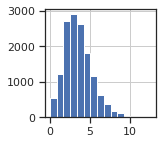

In [59]:
# Wind features: Boolean saying whether wind speed was above or below a certain threshold

# Distribution of wind speed
daily_df["Wind_speed"].hist(bins=15, figsize=(2, 2))

# Define 'calm day' features
calm_quantiles = [0.2, 0.4]
for quantile in calm_quantiles:
    upper_threshold = daily_df["Wind_speed"].quantile(quantile)
    print("Q%s: %s m/s" % (quantile, upper_threshold))
    daily_df["Wind_under_Q%s" % quantile] = daily_df["Wind_speed"] < upper_threshold

print("\n")

# Define 'windy day' features
windy_quantiles = [0.6, 0.8]
for quantile in windy_quantiles:
    lower_threshold = daily_df["Wind_speed"].quantile(quantile)
    print("Q%s: %s m/s" % (quantile, lower_threshold))
    daily_df["Wind_over_Q%s" % quantile] = daily_df["Wind_speed"] > lower_threshold

print(daily_df[["Wind_speed", "Wind_under_Q0.2", "Wind_over_Q0.6"]].head())

## Add temperature-related features

Later in the analysis I was finding that PET was coming out as a significant feature relating to biol. E.g. winter PET correlating with summer cyanobacterial biovolume. I think this could be more about ice thickness and duration, which I can't find long term records for. Instead, lets calculate winter freezing days (days where T<0), and assume the more subzero days the thicker the ice and the longer the ice duration.

In [60]:
daily_df['Temp_subzero'] = daily_df['Temp']<0.
daily_df[['Temp','Temp_subzero']].head()

,Temp,Temp_subzero
Date,,
1980-01-01,-4.758278,True
1980-01-02,-8.821736,True
1980-01-03,-15.280719,True
1980-01-04,-12.965066,True
1980-01-05,-5.304253,True


# Resample

In this notebook, we:
1) pick out the peak chl-a or cyanobacteria value per year. This single maximum value is the value used for chl-a and cyano throughout the rest of the notebook.
2) using the date of this peak, count back 30, 60 or 90 days and calculate means or sums of the potential explanatory variable over this "pre-peak" time window.

Results of these two analyses are stored in "yr_df", and then the same correlation coefficients and scatterplot matrices are calculated as in the 6 month aggregation notebook.

## User input

In [79]:
days_before_peak = 90

In [80]:
# Set the aggregation method for different variables

vars_to_sum = ["Pptn", "Rain_day", "Pptn_intense", "PET", "Q", "Temp_subzero"]

# Add wind cols to vars to sum
wind_cols = []
for q in calm_quantiles:
    wind_cols.append("Wind_under_Q%s" % q)
for q in windy_quantiles:
    wind_cols.append("Wind_over_Q%s" % q)
vars_to_sum += wind_cols

vars_to_average = [
    "TP_catch",
    "PTI",
    "Temp",
    "Biovolume",
    "rel_res_time",
    "colour_lake",
    "TP_lake",
    # "chl-a_lake",
    "Wind_speed",
]

vars_to_max = ["CyanoBiovol", "chl-a_lake"]

if basin == "Van2" and inc_Van1 == 1:
    vars_to_average.extend(["colour_van1", "TP_van1", "chl-a_van1"])

agg_method_dict = {}  # Key: var, returns aggregation method
for var in daily_df.columns:
    if var in vars_to_sum:
        method = np.sum
    elif var in vars_to_average:
        method = np.nanmean
    elif var in vars_to_max:
        method = np.nanmax
    else:
        method = None
    agg_method_dict[var] = method

agg_method_dict

{'Pptn': <function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
 'Temp': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'Wind_speed': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'PET': <function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
 'Q': <function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
 'TP_catch': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'chl-a_lake': <function numpy.nanmax(a, axis=None, out=None, keepdims=<no value>)>,
 'TP_lake': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'colour_lake': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'CyanoBiovol': <function numpy.nanmax(a, axis=None, out=None

In [81]:
yr_df_dict = {}  # keys: "cyano", "chla". Returns yr_df

var_dict = {"cyano": "CyanoBiovol", "chla": "chl-a_lake"}  # for naming

for var in ["cyano", "chla"]:
    long_var = var_dict[var]

    # Find annual peak of cyano or chla and add to new yr_df (annually aggregated values)
    yr_df = (daily_df[long_var].resample("Y", closed="left").agg(np.nanmax)).to_frame()
    # Remove frequncy info from index so all plotting works right & reindex to just year
    yr_df.index.freq = None
    yr_df.index = yr_df.index.year

    yr_df = pd.concat([yr_df, pd.DataFrame(columns=["peak_date", "peak_day"])])

    # Find date when annual maximum occurred
    for year_group in daily_df.groupby(daily_df.index.year):
        year = year_group[0]
        peak_date = year_group[1][long_var].idxmax()
        yr_df.loc[year, "peak_date"] = peak_date

    yr_df["peak_date"] = pd.to_datetime(yr_df["peak_date"])
    yr_df["peak_day"] = yr_df["peak_date"].dt.dayofyear

    # Set up for calculating pre-peak summaries for other variables
    extra_cols = daily_df.drop(long_var, axis=1).columns
    yr_df = pd.concat([yr_df, pd.DataFrame(columns=extra_cols)])

    groups = daily_df.copy().groupby(daily_df.index.year)
    for group in groups:
        yr = group[0]
        peak_date = yr_df.loc[yr, "peak_date"]
        daily_data = group[1].loc[
            peak_date - pd.Timedelta(days_before_peak, unit="D") : peak_date
        ]
        aggregated = daily_data.agg(agg_method_dict)
        aggregated.name = yr
        yr_df.loc[yr, aggregated.index] = aggregated.values

    yr_df = yr_df.loc[1980:2018, :]  # Drop 2019 as not complete

    # Summing over seasons gives 0 for Q & PET due to no data. Replace with NaNs
    for sum_var in ["Q", "PET", "Pptn"]:
        yr_df.loc[yr_df[sum_var] == 0.0, sum_var] = np.NaN

    yr_df_dict[var] = yr_df

    # Output to csv
    yr_df.to_csv(
        os.path.join(
            out_file,
            "%s_%s_peak_%s_prepeak_summary_for_explanatoryvars_%s_metdata.csv"
            % (basin, var, days_before_peak, met_source),
        )
    )

print("chla:")
print(yr_df_dict["chla"].tail())
print("cyano:")
print(yr_df_dict["cyano"].tail())

chla:
      chl-a_lake  peak_date  peak_day        Pptn       Temp Wind_speed  \
2014        17.0 2014-06-10     161.0  163.398196   9.578178   3.548352   
2015        34.0 2015-08-19     231.0  283.790271  14.839259   3.952747   
2016        16.0 2016-08-15     228.0  279.090196  16.208895   3.812088   
2017        21.0 2017-07-31     212.0  184.272861  14.849319   3.773626   
2018        16.0 2018-10-08     281.0  195.961011  15.870764   4.084615   

             PET        Q   TP_catch    TP_lake colour_lake CyanoBiovol  \
2014  177.292787  268.432  56.076923      20.25      58.825       0.113   
2015  324.241685  274.413     51.875  22.714286        47.0       0.233   
2016  348.780932   78.538       58.0  18.928571        52.0       0.163   
2017  323.998905  221.748  32.285714  19.142857   43.333333       0.232   
2018         NaN   25.526        NaN       19.0        30.0       0.614   

     Rain_day Pptn_intense Wind_under_Q0.2 Wind_under_Q0.4 Wind_over_Q0.6  \
2014     25.0  

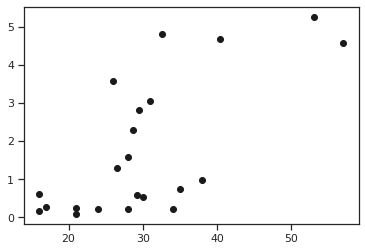

In [82]:
x = yr_df_dict['chla']['chl-a_lake']
y = yr_df_dict['cyano']['CyanoBiovol']
plt.plot(x, y, 'ko')

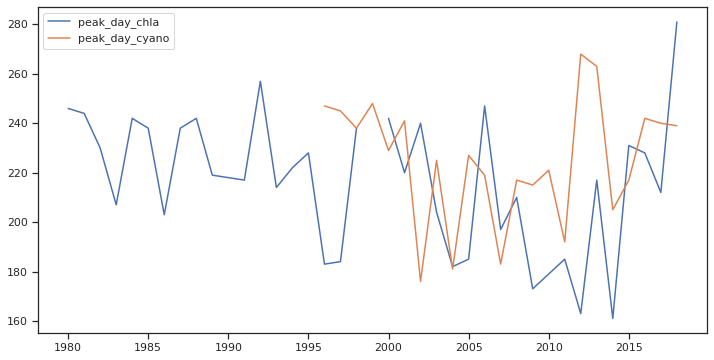

In [83]:
peak_day_df = pd.concat([yr_df_dict['chla']['peak_day'],yr_df_dict['cyano']['peak_day']], axis=1)
peak_day_df.columns=['peak_day_chla','peak_day_cyano']
peak_day_df[['peak_day_chla', 'peak_day_cyano']].plot(figsize=(12,6))
plt.show()

In [84]:
sorted(yr_df.columns)

['CyanoBiovol',
 'PET',
 'Pptn',
 'Pptn_intense',
 'Q',
 'Rain_day',
 'TP_catch',
 'TP_lake',
 'Temp',
 'Temp_subzero',
 'Wind_over_Q0.6',
 'Wind_over_Q0.8',
 'Wind_speed',
 'Wind_under_Q0.2',
 'Wind_under_Q0.4',
 'chl-a_lake',
 'colour_lake',
 'peak_date',
 'peak_day']

# Correlations and scatterplots

In [85]:
def correlation_stats(df, var, cols_to_drop, days_before_peak):

    long_var = var_dict[var]

    cur_df = yr_df_dict[var].drop(cols_to_drop, axis=1).astype(float)
    print("data rows in raw df: %s" % len(cur_df))

    # Drop any rows where target var is a NaN
    cur_df.dropna(subset=[long_var], inplace=True)
    print("data rows after dropping NaNs in target variable: %s" % len(cur_df))

    X = cur_df.drop([long_var], axis=1)
    y = cur_df[long_var]
    corr_df = X.corrwith(y, method="pearson")
    corr_df.sort_values().to_csv(
        "%s_corrcoeffs_%s_%sdays_prepeak_%smetdata.csv"
        % (basin, var, days_before_peak, met_source)
    )
    print(
        "correlation coefficients, aggregation over %s days before %s peak:"
        % (days_before_peak, var)
    )

    mapping = {
        "CyanoBiovol": "cyano",
        "PET": "PET",
        "Pptn": "P",
        "Pptn_intense": "High P",
        "Q": "Q",
        "Rain_day": "P count",
        "TP_catch": "TP catch",
        "TP_lake": "TP",
        "Temp": "T",
        "Temp_subzero": "T>0",
        "Wind_over_Q0.6": "w_Q6",
        "Wind_over_Q0.8": "w_Q8",
        "Wind_speed": "w",
        "Wind_under_Q0.2": "w_Q2",
        "Wind_under_Q0.4": "w_Q4",
        "chl-a_lake": "chla",
        "colour_lake": "color",
        "peak_date": "peak_date",
        "peak_day": "peak_day",
    }
    cur_df = cur_df.rename(columns=mapping)
    # pd.plotting.scatter_matrix(cur_df, figsize=(14,14));
    # plt.savefig("scattermatrix_%s_%s_%s_%s.png" % (basin, met_source, var, days_before_peak))
    corr_df.name = days_before_peak
    corr_df.sort_values().to_csv(
        os.path.join(
            corr_coeff_folder,
            "corr_coeffs_%s_%sdaysPrePeak_%s.csv" % (var, days_before_peak, met_source)
        )
    )

    return corr_df.sort_values()

In [86]:
var = 'chla'

cols_to_drop = [
 'CyanoBiovol',
 'PET',
 'Temp_subzero',
 'TP_catch',
 'peak_date',
 'peak_day',
]
corr_df = correlation_stats(yr_df_dict[var], var, cols_to_drop, days_before_peak)
corr_df

data rows in raw df: 39
data rows after dropping NaNs in target variable: 38
correlation coefficients, aggregation over 90 days before chla peak:


Wind_over_Q0.8    -0.321150
Wind_speed        -0.231568
Wind_over_Q0.6    -0.152888
Q                 -0.099798
Rain_day          -0.079761
Pptn              -0.010484
Temp               0.033258
colour_lake        0.104117
Pptn_intense       0.114411
Wind_under_Q0.4    0.116547
Wind_under_Q0.2    0.127937
TP_lake            0.358825
Name: 90, dtype: float64

**Chl-a, vars before peak**

30 days prior to peak:
- All ccs less than 0.25 (absolute)
- Strongest are with wind speed, wind under/over 0.2/0.8 (windier -> lower chl-a) and TP lake (0.21)

60 days prior to peak:
- Similar story, but CCs a little bit higher
- TP_lake now highest CC (0.34), followed by wind>Q8 (-0.31), wind speed (-0.25)

90 days prior to peak:
- Similar to 60 days (TP_lake is 0.36, Q0.8 wind -0.32, wind speed -0.23). All others v. low
- Calm days drops down to v. low

Summary of strongest correlations:
- lake_TP: 0.21 (30 days) to 0.36 (90 days)
- wind: wind speed (14 days: -0.35, 30 days: -0.24), >Q0.8 (14:-0.32, 60, 90 days; CCs -0.31, -0.32)

**Comparison to 6 month aggregation:**
Similar results.
CC with lake_TP is now weaker (was 0.58, now down to 0.2-0.4), but still one of strongest correlations. Wind variables are still the only met variables that appear to be important, and they're as important as lake TP concentration. Nothing else comes out (e.g. temperature).

In [87]:
var = 'cyano'

cols_to_drop = [
 'PET',
 'Temp_subzero',
 'TP_catch',
 'peak_date',
 'peak_day',
]
corr_df = correlation_stats(yr_df_dict[var], var, cols_to_drop, days_before_peak)
corr_df

data rows in raw df: 39
data rows after dropping NaNs in target variable: 23
correlation coefficients, aggregation over 90 days before cyano peak:


colour_lake       -0.407909
Temp              -0.144709
Rain_day          -0.121594
Pptn              -0.107906
Q                 -0.096899
Wind_over_Q0.6    -0.000048
Wind_under_Q0.4    0.005679
Wind_over_Q0.8     0.043560
Wind_speed         0.045383
Pptn_intense       0.050266
Wind_under_Q0.2    0.125932
TP_lake            0.508460
chl-a_lake         0.549212
Name: 90, dtype: float64

**Cyanomax correlations in Van 2:**

Strongest correlations are with:
- TP_lake. The correlation coefficients decrease as the pre-peak window increases, from 0.71 (n=14) to 0.51 (n=90)
- chl-a_lake. Fairly constant CC wrt window size. Around 0.48 (n=14) to 0.55 (n=90)
- lake colour. Variable, in range -0.33 (14) to -0.45 (60)
- Delivery/hydrology: strong'ish correlations with Q, rain days and precipitation amount for windows LESS THAN 90. Variable according to aggregation window. E.g. Q is around -0.32 for 14 and 30 days, then small. Rain days is -0.41,-0.45 for 30 and 60 days, otherwise small. Precipitation amount is -0.36, -0.39 for 30 and 60 days. Some consistent indication that the larger the inflow/rain the lower the cyanobacterial biomass.
- Not much with wind, nothing with temperature

**i.e. comparison to whole season: similar correlations with TP_lake, chl-a_lake and lake_colour. Similar lack of correlation with temperature and wind. BUT, some indication that freshwater delivery matters (residence time/turnover).**

Previous comments, from looking at a 6-monthly growing season temporal aggregation of data:

- chl-a_lake (0.77). Same as when split into two seasons, CCs just as high
- TP_lake (0.58). Tiny bit smaller CC than late summer but not much (0.62), higher than early summer (0.42)
- Previous summer: chl-a (0.56), av cyano (0.55), TP (0.49). Similar to early summer, bit smaller CCs than late summer (0.67 for LS mean cyano)
- Lake colour: previous summer (-0.50), this summer (-0.44). More coloured means less cyano, which makes sense. But correlation vs causation? Don't see colour effect with chl-a. Would we expect cyano to be affected, and not chl-a? Have asked Sigrid Haande this in the past, but can't remember the answer. Think perhaps yes, because they use a different bit of the light spectrum. Similar to early & late summer CCs.
- Wind variables: not much. Wind_under_Q0.2 (0.30), and winter wind vars (>Q0.6 -0.38, mean speed -0.31). CCs of about 0.4 for early & late summer.
- Temp: negative correlations if anything! Current season (-0.2), previous summer -0.26

Spearman's rank:
- chl-a_lake (0.83)
- Previous summer cyano (0.71), chl-a (0.70), TP (0.63)
- Colour (previous summer: -0.47, this summer: -0.45)